In [2]:
import sys,numpy,matplotlib
import scanpy,velocyto

/Users/alomana/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# 1. scanpy analysis

In [3]:
idata=scanpy.read_csv('/Volumes/omics4tb2/alomana/projects/mscni/data/scanpy/count.file.all.day.clean.csv')
adata=idata.transpose()

scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)

adata.obs['n_counts'] = adata.X.sum(axis=1)

scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
scanpy.pp.log1p(adata)

adata.raw = adata

scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=6,min_disp=0.25) # 2,851
adata = adata[:, adata.var['highly_variable']]

scanpy.pp.regress_out(adata, ['n_counts'])
scanpy.pp.scale(adata, max_value=10)

scanpy.tl.pca(adata,svd_solver='arpack')
scanpy.pp.neighbors(adata,n_neighbors=12,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)

In [72]:
adata

AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [8]:
cell_cluster_map=adata.obs['louvain'].to_dict()
last_day_ids=[element for element in list(cell_cluster_map.keys()) if 'day24' in element]
print(len(last_day_ids),last_day_ids[:10])

783 ['AAACGGGAGGAGCGAG_M397.day24', 'AAACGGGTCTCCGGTT_M397.day24', 'AAAGATGAGGTTACCT_M397.day24', 'AAAGATGCATGGGACA_M397.day24', 'AAAGCAATCCAACCAA_M397.day24', 'AAAGTAGAGGCCCTTG_M397.day24', 'AAAGTAGCAGCTATTG_M397.day24', 'AAAGTAGGTATTCGTG_M397.day24', 'AAAGTAGTCCCAACGG_M397.day24', 'AAATGCCCAGGAATGC_M397.day24']


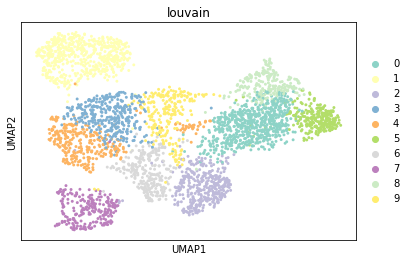

In [9]:
scanpy.pl.umap(adata,color=['louvain'],palette='Set3')

# 2. velocity analysis

In [65]:
vlm=velocyto.VelocytoLoom("/Volumes/omics4tb2/alomana/projects/mscni/results/velocyto/combined.loom")

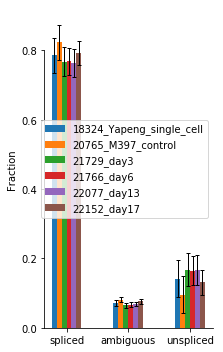

In [66]:
vlm.plot_fractions()

In [67]:
vlm.normalize("S",size=True,log=True)
vlm.normalize("U",size=True,log=False)

In [68]:
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > numpy.percentile(vlm.initial_Ucell_size, 0.5))

In [69]:
vlm.set_clusters(adata.obs['louvain'].tolist())

In [70]:
print(len(adata.obs['louvain'].tolist()))

3477


In [71]:
vlm.score_detection_levels()
vlm.filter_genes(by_detection_levels=True)

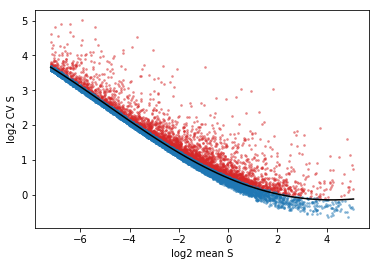

In [57]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [78]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
#vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True)

In [79]:
vlm._normalize_S(relative_size=vlm.S.sum(0),target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),target_size=vlm.U.sum(0).mean())
# check the alternative of tutorial 1

In [80]:
vlm.perform_PCA()
vlm.knn_imputation(n_pca_dims=20, k=500, balanced=True, b_sight=3000, b_maxl=1500, n_jobs=8)

vlm.perform_PCA()
nei=int(0.025*969)
print(nei)
vlm.knn_imputation(k=nei,n_pca_dims=20,balanced=True,n_jobs=8)
vlm.fit_gammas()

KeyboardInterrupt: 

In [ ]:
vlm.fit_gammas()


In [ ]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)